# ADMM Pruning for Efficient Deep Learning

In [1]:
# install dependencies
google_colab = True

if google_colab:
    !pip install great-tables
else:
    !pip install great-tables pandas matplotlib seaborn numpy
    !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.2/607.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00


In [2]:
# import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from great_tables import GT, style, loc

import torch, numpy as np, random
from torch.nn import CrossEntropyLoss, Linear

from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models as m

In [3]:
# set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Classes

In [4]:
# uniform sparsity pruner
class FineGrainedPruner:
    def __init__(self, target_sparsity=0):
        self.target_sparsity = target_sparsity
        self.masks = []

    @torch.no_grad()
    def apply_prune(self, model, compute_masks=True):
        if compute_masks or not self.masks:
            self.masks = FineGrainedPruner.prune(model, self.target_sparsity)

        i = 0
        for name, param in model.named_parameters():
            if 'weight' in name:
                param *= self.masks[i]
                i += 1

    @staticmethod
    @torch.no_grad()
    def prune(model, target_sparsity=0):
        masks = []
        for name, param in model.named_parameters():
            if 'weight' in name:
                masks.append(FineGrainedPruner.get_mask(param, target_sparsity))
        return masks

    @staticmethod
    @torch.no_grad()
    def get_mask(param, sparsity=0):
        sparsity = min(max(0.0, sparsity), 1.0)

        if sparsity == 1.0:
            param.zero_()
            return torch.zeros_like(param)
        elif sparsity == 0.0:
            return torch.ones_like(param)

        num_elements = param.numel()
        num_zeros = round(sparsity * num_elements)

        importance = param.abs()
        threshold = torch.kthvalue(importance.flatten(), num_zeros).values

        mask = (param.abs() > threshold).float()
        param.mul_(mask)

        return mask

In [5]:
class BaseTrainer():
    def __init__(self,
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        target_sparsity=0.0,
        pretrained=False,
        verbose=False,
        name=None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.target_sparsity = target_sparsity
        self.pruner = FineGrainedPruner(target_sparsity)
        self.pretrained = pretrained
        self.verbose = verbose
        self.name = name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def __call__(self, epochs):
        history = {}

        if not self.pretrained:
            if self.verbose:
                print('training model...')
            history['train'] = self.train(epochs['train'])
        else:
            if self.verbose:
                print('using pretrained model...')
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-trained.pth')

        self.pruner.apply_prune(self.model)
        history['prune'] = self.test()
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-pruned.pth')

        if self.verbose:
            print('retraining model...')
        history['retrain'] = self.retrain(epochs['retrain'])
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-retrained.pth')

        return self.model, history

    def train(self, epochs):
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
        }

        best_loss, stop = float('inf'), 0
        for epoch in range(epochs):

            self.model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()

                output = self.model(data)
                loss = self.criterion(output, target)

                loss.backward()
                self.optimizer.step()

                history['train_loss'].append(loss.item())
            loss, acc = self.test()

            history['val_loss'].append(loss)
            history['val_acc'].append(acc)

            if not epoch:
                best_loss = loss
            else:
                improvement = (best_loss - loss) / best_loss
                if improvement < 0.001: # stopping criterion
                    stop += 1
                    if stop > 25:
                        break
                else:
                    stop = 0
                if loss < best_loss:
                    best_loss = loss

        return history

    def retrain(self, epochs):
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
        }

        best_loss, stop = float('inf'), 0
        for epoch in range(epochs):

            self.model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()

                output = self.model(data)
                loss = self.criterion(output, target)

                loss.backward()
                self.optimizer.step()
                self.pruner.apply_prune(self.model, compute_masks=False)

                history['train_loss'].append(loss.item())
            loss, acc = self.test()

            history['val_loss'].append(loss)
            history['val_acc'].append(acc)

            if not epoch:
                best_loss = loss
            else:
                improvement = (best_loss - loss) / best_loss
                if improvement < 0.001: # stopping criterion
                    stop += 1
                    if stop > 25:
                        break
                else:
                    stop = 0
                if loss < best_loss:
                    best_loss = loss
        return history

    def test(self):
        reduction = self.criterion.reduction
        self.criterion.reduction = 'sum'

        loss, correct = 0, 0

        self.model.eval()
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)
                loss += self.criterion(output, target).item()

                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        loss /= len(self.val_loader.dataset)
        accuracy = 100 * correct / len(self.val_loader.dataset)

        self.criterion.reduction = reduction
        return loss, accuracy


In [6]:
class ADMMLoss():
    def __init__(self, criterion, lamda=5e-4, rho=0.01, device='cpu'):
        self.criterion = criterion
        self.lamda, self.rho = lamda, rho
        self.device = torch.device(device)

    # eq 7
    def __call__(self, output, target, model, Z, U):
        obj_loss = self.criterion(output, target)
        l2_loss = torch.zeros((), device=self.device)
        constraint_loss = torch.zeros((), device=self.device)

        i = 0
        for name, param in model.named_parameters():
            if 'weight' in name:
                w, z, u = param, Z[i].to(self.device), U[i].to(self.device)
                i += 1

                # l2 norm
                l2_loss += self.lamda * w.norm()

                # constraint penalty
                constraint_loss += self.rho * torch.norm(w - z - u)
        loss = obj_loss + l2_loss + constraint_loss

        obj_loss = obj_loss.item()
        l2_loss = l2_loss.item()
        constraint_loss = constraint_loss.item()

        return loss, (obj_loss, l2_loss, constraint_loss)

In [7]:
class ADMMTrainer():
    def __init__(self,
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        target_sparsity=0.0,
        pretrained=False,
        verbose=False,
        name=None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.target_sparsity = target_sparsity
        self.pruner = FineGrainedPruner(target_sparsity)
        self.pretrained = pretrained
        self.verbose = verbose
        self.name = name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def __call__(self, epochs):
        history = {}

        if not self.pretrained:
            if self.verbose:
                print('pretraining model...')
            history['pretrain'] = self.pretrain(epochs['pretrain'])
        else:
            if self.verbose:
                print('using pretrained model...')
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-pretrained.pth')

        if self.verbose:
            print('training model...')
        history['train'] = self.train_ADMM(epochs['train'])
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-trained.pth')
        self.pruner.apply_prune(self.model)
        history['prune'] = self.test()
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-pruned.pth')

        if self.verbose:
            print('retraining model...')
        history['retrain'] = self.retrain(epochs['retrain'])
        if self.name:
            torch.save(self.model.state_dict(), f'{self.name}-retrained.pth')

        return self.model, history

    def pretrain(self, epochs):
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
        }

        best_loss, stop = float('inf'), 0
        for epoch in range(epochs):

            self.model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()

                output = self.model(data)
                loss = self.criterion(output, target)

                loss.backward()
                self.optimizer.step()

                history['train_loss'].append(loss.item())
            loss, acc = self.test()

            history['val_loss'].append(loss)
            history['val_acc'].append(acc)

            if not epoch:
                best_loss = loss
            else:
                improvement = (best_loss - loss) / best_loss
                if improvement < 0.001: # stopping criterion
                    stop += 1
                    if stop > 25:
                        break
                else:
                    stop = 0
                if loss < best_loss:
                    best_loss = loss
        return history

    def train_ADMM(self, epochs):
        history = {
            'train_loss': [],
            'obj_loss': [],
            'l2_loss': [],
            'constraint_loss': [],
            'val_loss': [],
            'val_acc': [],
        }

        criterion = ADMMLoss(self.criterion, device=self.device)
        Z, U = self.init_ZU()

        best_loss, stop = float('inf'), 0
        for epoch in range(epochs):

            self.model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()

                output = self.model(data)
                loss, (obj_loss, l2_loss, constraint_loss) = criterion(output, target, self.model, Z, U)

                loss.backward()
                self.optimizer.step()

                history['train_loss'].append(loss.item())
                history['obj_loss'].append(obj_loss)
                history['l2_loss'].append(l2_loss)
                history['constraint_loss'].append(constraint_loss)
            W = self.update_W()
            Z = self.update_Z(W, U)
            U = self.update_U(U, W, Z)

            loss, acc = self.test()

            history['val_loss'].append(loss)
            history['val_acc'].append(acc)

            if not epoch:
                best_loss = loss
            else:
                improvement = (best_loss - loss) / best_loss
                if improvement < 0.001: # stopping criterion
                    stop += 1
                    if stop > 25:
                        break
                else:
                    stop = 0
                if loss < best_loss:
                    best_loss = loss
        return history

    def retrain(self, epochs):
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
        }

        best_loss, stop = float('inf'), 0
        for epoch in range(epochs):

            self.model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()

                output = self.model(data)
                loss = self.criterion(output, target)

                loss.backward()
                self.optimizer.step()
                self.pruner.apply_prune(self.model, compute_masks=False)

                history['train_loss'].append(loss.item())
            loss, acc = self.test()

            history['val_loss'].append(loss)
            history['val_acc'].append(acc)

            if not epoch:
                best_loss = loss
            else:
                improvement = (best_loss - loss) / best_loss
                if improvement < 0.001: # stopping criterion
                    stop += 1
                    if stop > 25:
                        break
                else:
                    stop = 0
                if loss < best_loss:
                    best_loss = loss
        return history

    def test(self):
        reduction = self.criterion.reduction
        self.criterion.reduction = 'sum'

        loss, correct = 0, 0

        self.model.eval()
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)
                loss += self.criterion(output, target).item()

                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        loss /= len(self.val_loader.dataset)
        accuracy = 100 * correct / len(self.val_loader.dataset)

        self.criterion.reduction = reduction
        return loss, accuracy

    def init_ZU(self):
        Z, U = [], []
        for name, param in self.model.named_parameters():
            if 'weight' in name:
                Z.append(param.detach().cpu().clone())
                U.append(torch.zeros_like(param).cpu())
        return Z, U

    # can be solved by stochastic gradient descent
    def update_W(self):
        W = []
        for name, param in self.model.named_parameters():
            if 'weight' in name:
                W.append(param.detach().cpu().clone())
        return W

    # eq 8
    def update_Z(self, W, U):
        Z = []
        for w, u in zip(W, U):
            z = w + u
            thresh = torch.quantile(torch.abs(z), self.target_sparsity)
            z = torch.where(torch.abs(z) < thresh, 0, z)
            Z.append(z)
        return Z

    # eq 5
    def update_U(self, U, W, Z):
        new_U = []
        for u, w, z in zip(U, W, Z):
            U.append(u + w - z)
        return U

## Dataset

In [8]:
NUM_CLASSES = 10

transforms = {
    'train': Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    'test': ToTensor(),
}
dataset = {
    'train': CIFAR10(
        root='data/cifar10',
        train=True,
        download=True,
        transform=transforms['train'],
    ),
    'test': CIFAR10(
        root='data/cifar10',
        train=False,
        download=True,
        transform=transforms['test'],
    )
}
dataloader = {
    'train': DataLoader(
        dataset['train'],
        batch_size=512,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    ),
    'test': DataLoader(
        dataset['test'],
        batch_size=512,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
}

gather_data = False

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


## Gather Data

In [9]:
gather_data = False

if gather_data:
    trainers = ['basetrainer', 'admmtrainer']
    models = ['mobilenetv2', 'mobilenetv3large', 'mobilenetv3small']

    history = {}
    for model_name in models:
        if model_name == 'mobilenetv2':
            model = m.mobilenet_v2(weights=m.MobileNet_V2_Weights.IMAGENET1K_V1)
        elif model_name == 'mobilenetv3large':
            model = m.mobilenet_v3_large(weights=m.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        elif model_name == 'mobilenetv3small':
            model = m.mobilenet_v3_small(weights=m.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        else:
            raise NotImplementedError()
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = Linear(in_features, NUM_CLASSES)

        for trainer_name in trainers:
            name = f'{model_name}-{trainer_name}'

            if trainer_name == 'basetrainer':
                trainer = BaseTrainer(
                    model=model,
                    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
                    criterion=CrossEntropyLoss(),
                    train_loader=dataloader['train'],
                    val_loader=dataloader['test'],
                    target_sparsity=0.5,
                    pretrained=False,
                    verbose=False,
                    name=name,
                )
            elif trainer_name == 'admmtrainer':
                trainer = ADMMTrainer(
                    model=model,
                    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
                    criterion=CrossEntropyLoss(),
                    train_loader=dataloader['train'],
                    val_loader=dataloader['test'],
                    target_sparsity=0.5,
                    pretrained=True,
                    verbose=False,
                    name=name,
                )
            else:
                raise NotImplementedError()

            print(f'start training {name}')

            set_seed()
            _, temp = trainer({
                'train': 1000,
                'retrain': 1000,
            })

            history[name] = temp
    with open('history.json', 'w') as f:
        json.dump(history, f, indent=4)
else:
    m.mobilenet_v2(weights=m.MobileNet_V2_Weights.IMAGENET1K_V1)
    m.mobilenet_v3_large(weights=m.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    m.mobilenet_v3_small(weights=m.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    with open('pretrained/history.json', 'r') as f:
        history = json.load(f)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 81.0MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 127MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 151MB/s]


## Visualization

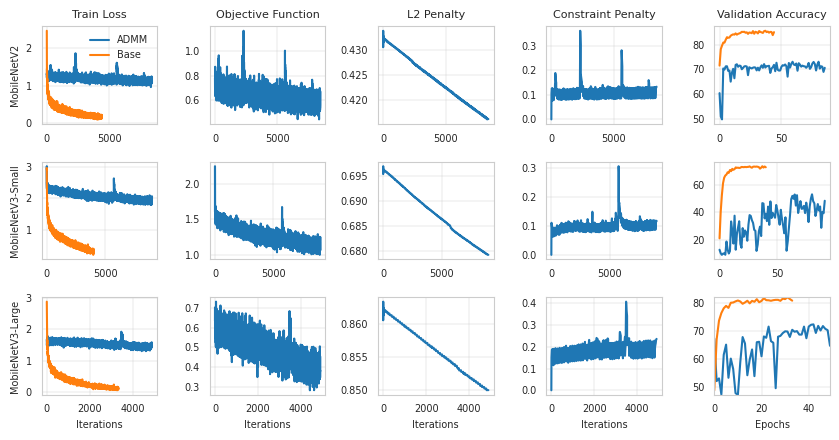

In [10]:
sns.set_style('whitegrid')

variants = [
    ('mobilenetv2',      'MobileNetV2'),
    ('mobilenetv3small', 'MobileNetV3-Small'),
    ('mobilenetv3large', 'MobileNetV3-Large'),
]

metrics = [
    ('train_loss',      'Train Loss'),
    ('obj_loss',        'Objective Function'),
    ('l2_loss',         'L2 Penalty'),
    ('constraint_loss', 'Constraint Penalty'),
    ('val_acc',         'Validation Accuracy'),
]

fig, axes = plt.subplots(3, 5, figsize=(8.5, 4.5))

for i, (key_prefix, row_title) in enumerate(variants):
    base_key = f'{key_prefix}-basetrainer'
    admm_key = f'{key_prefix}-admmtrainer'

    for j, (metric_key, metric_label) in enumerate(metrics):
        ax = axes[i, j]

        if metric_key in ('train_loss', 'val_acc'):
            base_vals = history[base_key]['train'][metric_key]
            admm_vals = history[admm_key]['train'][metric_key]

            if j in (0, 4):
                sns.lineplot(ax=ax, x=range(len(admm_vals)), y=admm_vals, label='ADMM')
                sns.lineplot(ax=ax, x=range(len(base_vals)), y=base_vals, label='Base')
            else:
                sns.lineplot(ax=ax, x=range(len(base_vals)), y=base_vals, label='Base')
                sns.lineplot(ax=ax, x=range(len(admm_vals)), y=admm_vals, label='ADMM')
        else:
            vals = history[admm_key]['train'][metric_key]
            sns.lineplot(ax=ax, x=range(len(vals)), y=vals)

        if i == 0:
            ax.set_title(metric_label, fontsize=8)
        if j == 0:
            ax.set_ylabel(row_title, fontsize=7)
        else:
            ax.set_ylabel('')

        if i == 2:
            ax.set_xlabel('Epochs' if metric_key == 'val_acc' else 'Iterations', fontsize=7)
        else:
            ax.set_xlabel('')

        ax.tick_params(axis='both', labelsize=7)
        ax.grid(True, linewidth=0.3)

        if metric_key in ('train_loss', 'val_acc') and not (i == 0 and j == 0):
            ax.get_legend().remove()

axes[0, 0].legend(loc='upper right', fontsize=7, frameon=False)

plt.margins(0)
plt.tight_layout()
plt.show()

In [11]:
models = ['mobilenetv2', 'mobilenetv3large', 'mobilenetv3small']
def count_params(name):
    if 'v2' in name:
        model = m.mobilenet_v2(weights=m.MobileNet_V2_Weights.IMAGENET1K_V1)
    elif 'v3large' in name:
        model = m.mobilenet_v3_large(weights=m.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    elif 'v3small' in name:
        model = m.mobilenet_v3_small(weights=m.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = Linear(in_features, NUM_CLASSES)

    model.load_state_dict(torch.load(f'pretrained/{name}.pth', map_location=torch.device('cpu')))
    return int(sum(torch.count_nonzero(p).item() for p in model.parameters()))

df = pd.DataFrame({
    'Model': ['MobileNetV2', 'MobileNetV3-S', 'MobileNetV3-L'],

    # Base – Before
    'Base Acc (before)':      [history[f'{m}-basetrainer']['train']['val_acc'][-1] for m in models],
    'Base Params (before)':   [count_params(f'{m}-basetrainer-trained') for m in models],
    'Base Iterations (before)':   [len(history[f'{m}-basetrainer']['train']['train_loss']) for m in models],

    # Base – After
    'Base Acc (after)':       [history[f'{m}-basetrainer']['retrain']['val_acc'][-1] for m in models],
    'Base Params (after)':    [count_params(f'{m}-basetrainer-retrained') for m in models],
    'Base Iterations (after)':    [len(history[f'{m}-basetrainer']['retrain']['train_loss']) for m in models],

    # ADMM – Before
    'ADMM Acc (before)':      [history[f'{m}-admmtrainer']['train']['val_acc'][-1] for m in models],
    'ADMM Params (before)':   [count_params(f'{m}-admmtrainer-trained') for m in models],
    'ADMM Iterations (before)':   [len(history[f'{m}-admmtrainer']['train']['train_loss']) for m in models],

    # ADMM – After
    'ADMM Acc (after)':       [history[f'{m}-admmtrainer']['retrain']['val_acc'][-1] for m in models],
    'ADMM Params (after)':    [count_params(f'{m}-admmtrainer-retrained') for m in models],
    'ADMM Iterations (after)':    [len(history[f'{m}-admmtrainer']['retrain']['train_loss']) for m in models],
})

def fmt_millions(x):
    return f"{x/1e6:.2f}M"

def fmt_thousands(x):
    return f"{x/1e3:.1f}k"

params_cols = [c for c in df.columns if 'Params' in c]
iters_cols  = [c for c in df.columns if 'Iter' in c]
acc_cols    = [c for c in df.columns if 'Acc' in c]

gt = (
    GT(df)
    .tab_header(
        title='Base/ADMM Performance Before/After Pruning'
    )

    .tab_spanner(
        label='Before Pruning',
        columns=['Base Acc (before)', 'Base Params (before)', 'Base Iterations (before)'],
        level=0, id='base_before'
    )
    .tab_spanner(
        label='After Pruning',
        columns=['Base Acc (after)', 'Base Params (after)', 'Base Iterations (after)'],
        level=0, id='base_after'
    )
    .tab_spanner(
        label='Before Pruning',
        columns=['ADMM Acc (before)', 'ADMM Params (before)', 'ADMM Iterations (before)'],
        level=0, id='admm_before'
    )
    .tab_spanner(
        label='After Pruning',
        columns=['ADMM Acc (after)', 'ADMM Params (after)', 'ADMM Iterations (after)'],
        level=0, id='admm_after'
    )

    .tab_spanner(
        label='Base',
        columns=[
            'Base Acc (before)', 'Base Params (before)', 'Base Iterations (before)',
            'Base Acc (after)',  'Base Params (after)',  'Base Iterations (after)'
        ],
        level=1, id='top_base'
    )
    .tab_spanner(
        label='ADMM',
        columns=[
            'ADMM Acc (before)', 'ADMM Params (before)', 'ADMM Iterations (before)',
            'ADMM Acc (after)',  'ADMM Params (after)',  'ADMM Iterations (after)'
        ],
        level=1, id='top_admm'
    )

    .cols_label(**{
        'Base Acc (before)': 'Acc',
        'Base Params (before)': 'Params',
        'Base Iterations (before)': 'Iters',
        'Base Acc (after)': 'Acc',
        'Base Params (after)': 'Params',
        'Base Iterations (after)': 'Iters',
        'ADMM Acc (before)': 'Acc',
        'ADMM Params (before)': 'Params',
        'ADMM Iterations (before)': 'Iters',
        'ADMM Acc (after)': 'Acc',
        'ADMM Params (after)': 'Params',
        'ADMM Iterations (after)': 'Iters',
    })

    .fmt_number(columns=acc_cols, decimals=2)

    .fmt(columns=params_cols, fns=fmt_millions)

    .fmt(columns=iters_cols, fns=fmt_thousands)

    .tab_style(
        style=style.text(weight='bold'),
        locations=loc.header()
    )
    .tab_style(
        style=style.fill(color='#f0f0f0'),
        locations=loc.header()
    )
    .tab_options(
        table_font_size='8pt',
        data_row_padding='3pt'
    )
)

gt

GT(_tbl_data=           Model  Base Acc (before)  Base Params (before)  \
0    MobileNetV2              85.06               2236682   
1  MobileNetV3-S              80.66               4214842   
2  MobileNetV3-L              72.47               1528106   

   Base Iterations (before)  Base Acc (after)  Base Params (after)  \
0                      4410             67.10              1126874   
1                      3332             68.48              2116706   
2                      4018             10.00               769042   

   Base Iterations (after)  ADMM Acc (before)  ADMM Params (before)  \
0                    12838              70.60               1627314   
1                     5586              64.57               4138673   
2                     6468              48.33               1485777   

   ADMM Iterations (before)  ADMM Acc (after)  ADMM Params (after)  \
0                      8428             72.08              1126874   
1                      4900             60.13              2116706   
2                      9016             35.97               769042   

   ADMM Iterations (after)  
0                     2646  
1                     2940  
2                     4214  , _body=<great_tables._gt_data.Body object at 0x7b2ba50244a0>, _boxhead=Boxhead([ColInfo(var='Model', type=<ColInfoTypeEnum.default: 1>, column_label='Model', column_align='left', column_width=None), ColInfo(var='Base Acc (before)', type=<ColInfoTypeEnum.default: 1>, column_label='Acc', column_align='right', column_width=None), ColInfo(var='Base Params (before)', type=<ColInfoTypeEnum.default: 1>, column_label='Params', column_align='right', column_width=None), ColInfo(var='Base Iterations (before)', type=<ColInfoTypeEnum.default: 1>, column_label='Iters', column_align='right', column_width=None), ColInfo(var='Base Acc (after)', type=<ColInfoTypeEnum.default: 1>, column_label='Acc', column_align='right', column_width=None), ColInfo(var='Base Params (after)', type=<ColInfoTypeEnum.default: 1>, column_label='Params', column_align='right', column_width=None), ColInfo(var='Base Iterations (after)', type=<ColInfoTypeEnum.default: 1>, column_label='Iters', column_align='right', column_width=None), ColInfo(var='ADMM Acc (before)', type=<ColInfoTypeEnum.default: 1>, column_label='Acc', column_align='right', column_width=None), ColInfo(var='ADMM Params (before)', type=<ColInfoTypeEnum.default: 1>, column_label='Params', column_align='right', column_width=None), ColInfo(var='ADMM Iterations (before)', type=<ColInfoTypeEnum.default: 1>, column_label='Iters', column_align='right', column_width=None), ColInfo(var='ADMM Acc (after)', type=<ColInfoTypeEnum.default: 1>, column_label='Acc', column_align='right', column_width=None), ColInfo(var='ADMM Params (after)', type=<ColInfoTypeEnum.default: 1>, column_label='Params', column_align='right', column_width=None), ColInfo(var='ADMM Iterations (after)', type=<ColInfoTypeEnum.default: 1>, column_label='Iters', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2baf838fb0>, _spanners=Spanners([SpannerInfo(spanner_id='base_before', spanner_level=0, spanner_label='Before Pruning', spanner_units=None, spanner_pattern=None, vars=['Base Acc (before)', 'Base Params (before)', 'Base Iterations (before)'], built=None), SpannerInfo(spanner_id='base_after', spanner_level=0, spanner_label='After Pruning', spanner_units=None, spanner_pattern=None, vars=['Base Acc (after)', 'Base Params (after)', 'Base Iterations (after)'], built=None), SpannerInfo(spanner_id='admm_before', spanner_level=0, spanner_label='Before Pruning', spanner_units=None, spanner_pattern=None, vars=['ADMM Acc (before)', 'ADMM Params (before)', 'ADMM Iterations (before)'], built=None), SpannerInfo(spanner_id='admm_after', spanner_level=0, spanner_label='After Pruning', spanner_units=None, spanner_pattern=None, vars=['ADMM Acc (after)', 'ADMM Params (after)', 'ADMM Iterations (after)'], built=None), Spann

In [12]:
model = m.mobilenet_v3_small(weights=m.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
in_features = model.classifier[-1].in_features
model.classifier[-1] = Linear(in_features, NUM_CLASSES)
weight_names = [name for name, _ in model.named_parameters() if 'weight' in name]

set_seed()
start_idx = random.randint(0, len(weight_names) - 3)
selected_names = weight_names[start_idx:start_idx + 3]

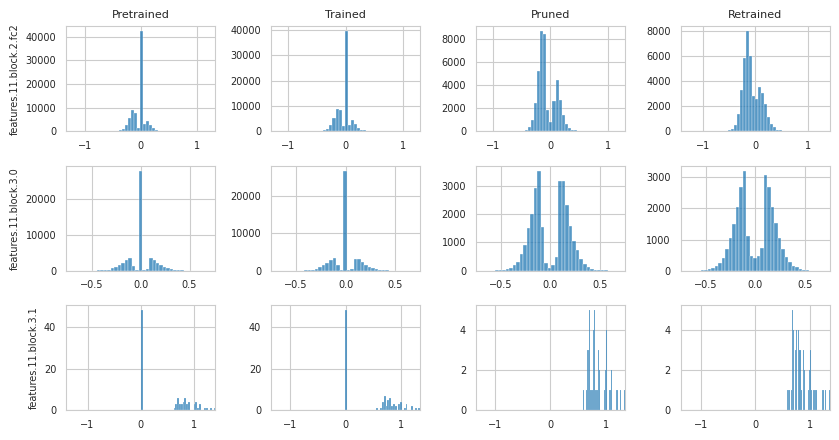

In [13]:
stages = ['pretrained', 'trained', 'pruned', 'retrained']

fig, axes = plt.subplots(3, 4, figsize=(8.5, 4.5))

for row, name in enumerate(selected_names):
    clean_name = name.replace('.weight', '')
    for col, stage in enumerate(stages):
        ax = axes[row, col]

        ckpt = torch.load(f'pretrained/mobilenetv3small-admmtrainer-{stage}.pth', map_location=torch.device('cpu'))
        model.load_state_dict(ckpt)

        weights = model.state_dict()[name].detach().cpu().numpy().ravel()

        if stage != 'pretrained':
            weights = weights[weights != 0]

        ma = np.max(np.abs(weights))
        ax.set_xlim(-ma, ma)

        sns.histplot(weights, bins=41, kde=False, ax=ax)

        if row == 0:
            ax.set_title(stage.capitalize(), fontsize=8)
        if col == 0:
            ax.set_ylabel(clean_name, fontsize=7)
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='both', labelsize=7)

plt.tight_layout()
plt.show()


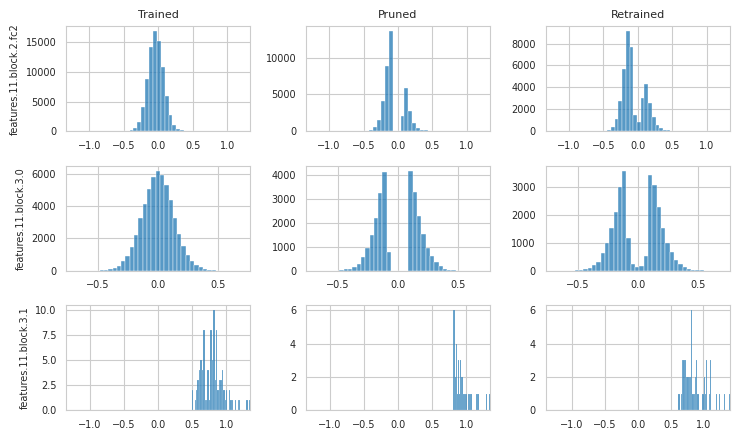

In [14]:
stages = ['trained', 'pruned', 'retrained']

fig, axes = plt.subplots(3, 3, figsize=(7.5, 4.5))

for row, name in enumerate(selected_names):
    clean_name = name.replace('.weight', '')
    for col, stage in enumerate(stages):
        ax = axes[row, col]

        ckpt = torch.load(f'pretrained/mobilenetv3small-basetrainer-{stage}.pth', map_location=torch.device('cpu'))
        model.load_state_dict(ckpt)

        weights = model.state_dict()[name].detach().cpu().numpy().ravel()
        weights = weights[weights != 0]

        ma = np.max(np.abs(weights))
        ax.set_xlim(-ma, ma)

        sns.histplot(weights, bins=41, kde=False, ax=ax)

        if row == 0:
            ax.set_title(stage.capitalize(), fontsize=8)
        if col == 0:
            ax.set_ylabel(clean_name, fontsize=7)
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='both', labelsize=7)

plt.tight_layout()
plt.show()


## References

[1] Cheng, H., Zhang, M., & Shi, J. Q. (2024). A Survey on Deep Neural Network Pruning: Taxonomy, Comparison, Analysis, and Recommendations. IEEE Transactions on Pattern Analysis and Machine Intelligence, 46(12), 10558–10578. https://doi.org/10.1109/TPAMI.2024.3447085

[2] Yuan, M., Bai, J., Jiang, F., & Du, L. (2024). A systematic DNN weight pruning framework based on symmetric accelerated stochastic ADMM. Neurocomputing, 575, 127327. https://doi.org/10.1016/j.neucom.2024.127327

[3] Zhang, T., Ye, S., Zhang, K., Tang, J., Wen, W., Fardad, M., & Wang, Y. (2018). A Systematic DNN Weight Pruning Framework using Alternating Direction Method of Multipliers. 184–199. https://openaccess.thecvf.com/content_ECCV_2018/html/Tianyun_Zhang_A_Systematic_DNN_ECCV_2018_paper.html